In [1]:
import xgboost as xgb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text
from sklearn.metrics import roc_auc_score

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('CreditScoring.csv')

In [5]:
df.head(5)

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [6]:
df.columns = df.columns.str.lower()

In [7]:
status_values = {
    0:'unk', 
    1:'ok',
    2: 'default'
}

df.status = df.status.map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
df.home = df.home.map(home_values)

marital_values = {
    0: 'unk',
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'seperated',
    5: 'divorced'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
}
df.records = df.records.map(records_values)

job_values = {
    0: 'unk',
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others'
}
df.job = df.job.map(job_values)

In [8]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [9]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [10]:
#turn inconsistent values to nan
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace = 99999999, value = np.nan)

In [11]:
df.status.value_counts()
df = df[df.status != 'unk'].reset_index(drop = True)

# Exploratory Analysis

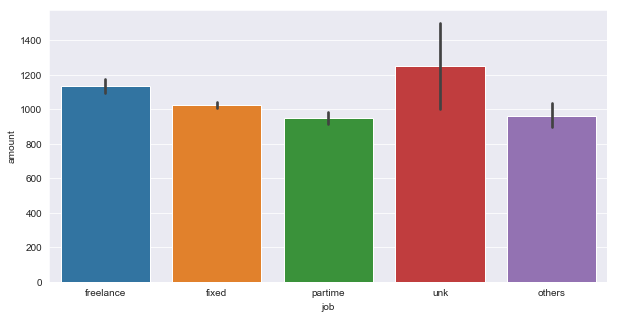

In [12]:
plt.figure(figsize = (10, 5))
sns.set_style('darkgrid')
sns.barplot(x = 'job', y= 'amount', data = df)

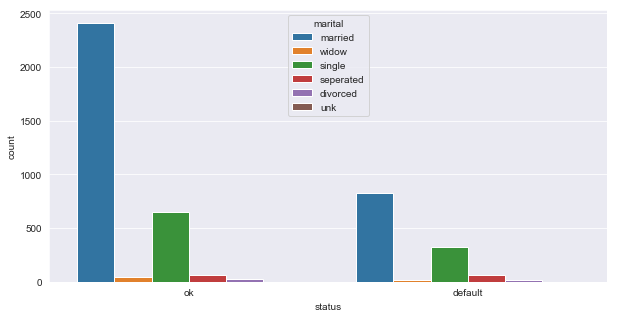

In [13]:
plt.figure(figsize = (10, 5))
sns.set_style('darkgrid')
sns.countplot(x = 'status', hue = 'marital', data = df)

# Validation_set

In [14]:
df_full_train, df_test = train_test_split(df, test_size = 0.20, random_state = 101)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 101)

df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)

y_train = (df_train.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values

del df_train['status']
del df_test['status']
del df_val['status']

# Encoding

In [15]:
train_dict = df_train.fillna(0).to_dict(orient = 'records')
val_dict = df_val.fillna(0).to_dict(orient = 'records')

dv = DictVectorizer(sparse = False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

In [16]:
model = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 30)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=30)

In [17]:
y_pred = model.predict_proba(X_val)[: , 1]

In [18]:
roc_auc_score(y_val, y_pred)

0.7907424611930477

In [19]:
print(export_text(model, feature_names = dv.get_feature_names()))

|--- seniority <= 2.50
|   |--- records=no <= 0.50
|   |   |--- seniority <= 1.50
|   |   |   |--- assets <= 2250.00
|   |   |   |   |--- expenses <= 53.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- expenses >  53.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- assets >  2250.00
|   |   |   |   |--- class: 1
|   |   |--- seniority >  1.50
|   |   |   |--- class: 1
|   |--- records=no >  0.50
|   |   |--- income <= 89.00
|   |   |   |--- amount <= 1162.50
|   |   |   |   |--- home=rent <= 0.50
|   |   |   |   |   |--- income <= 51.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- income >  51.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- home=rent >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- amount >  1162.50
|   |   |   |   |--- time <= 54.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- time >  54.00
|   |   |   |   |   |--- class: 1
|   |   |--- income >  89.00
|   |   |   |--- job=partime <= 0.50
|   |   |   | 

In [20]:
# train with random_forest_classifier
rf = RandomForestClassifier(n_estimators = 50, max_depth = 10, min_samples_leaf = 3,
                            n_jobs = -1, random_state = 1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=50,
                       n_jobs=-1, random_state=1)

In [21]:
y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
auc

0.8266751829055858

In [22]:
#train with gradient boosting
feature =dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = feature)
d_val= xgb.DMatrix(X_val, label = y_val, feature_names = feature)

In [77]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round = 140)

[04:36:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [78]:
y_pred = model.predict(d_val)
roc_auc_score(y_val, y_pred)

0.8344817352481968

In [79]:
watchlist = [(dtrain, 'train'), (d_val, 'val')]

In [80]:
%%capture output
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals = watchlist, verbose_eval = 5,
                  num_boost_round = 140)


In [71]:
print(output.stdout)

[0]	train-auc:0.77295	val-auc:0.75654
[5]	train-auc:0.81659	val-auc:0.78694
[10]	train-auc:0.84444	val-auc:0.80829
[15]	train-auc:0.85624	val-auc:0.80987
[20]	train-auc:0.86269	val-auc:0.81633
[25]	train-auc:0.86978	val-auc:0.82126
[30]	train-auc:0.87492	val-auc:0.82486
[35]	train-auc:0.88064	val-auc:0.82697
[40]	train-auc:0.88508	val-auc:0.82839
[45]	train-auc:0.88844	val-auc:0.83011
[50]	train-auc:0.89237	val-auc:0.82958
[55]	train-auc:0.89637	val-auc:0.83135
[60]	train-auc:0.89915	val-auc:0.83222
[65]	train-auc:0.90245	val-auc:0.83320
[70]	train-auc:0.90480	val-auc:0.83499
[75]	train-auc:0.90750	val-auc:0.83474
[80]	train-auc:0.91019	val-auc:0.83500
[85]	train-auc:0.91147	val-auc:0.83513
[90]	train-auc:0.91350	val-auc:0.83546
[95]	train-auc:0.91539	val-auc:0.83505
[100]	train-auc:0.91733	val-auc:0.83479
[105]	train-auc:0.91889	val-auc:0.83478
[110]	train-auc:0.92109	val-auc:0.83451
[115]	train-auc:0.92287	val-auc:0.83445
[120]	train-auc:0.92402	val-auc:0.83411
[125]	train-auc:0.9250

In [81]:
def parse_xgb_output(output):
    results = []
   
    
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        results.append((it, train, val))
    columns = ['num_iter', 'train_auc', 'val_auc']   
    df_results = pd.DataFrame(results, columns = columns)
    return df_results

In [82]:
df_score = parse_xgb_output(output)

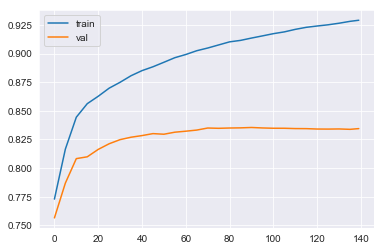

In [83]:
plt.plot(df_score.num_iter, df_score.train_auc, label = 'train' )
plt.plot(df_score.num_iter, df_score.val_auc, label = 'val')
plt.legend()

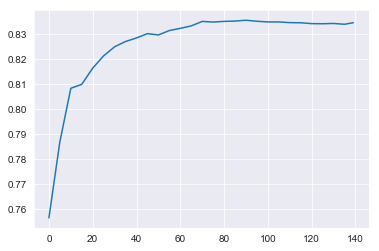

In [84]:
plt.plot(df_score.num_iter, df_score.val_auc, label = 'val')

# Selecting the best model

In [88]:
dt = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 30)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=30)

In [89]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.790877946812217

In [86]:
rf = RandomForestClassifier(n_estimators = 50, max_depth = 10, min_samples_leaf = 3,
                            n_jobs = -1, random_state = 1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=50,
                       n_jobs=-1, random_state=1)

In [90]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8266751829055858

In [91]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,num_boost_round = 140)


In [93]:
y_pred = model.predict(d_val)
roc_auc_score(y_val, y_pred)

0.8344817352481968

In [96]:
#training the final model with xgboost
df_full_train = df_full_train.reset_index(drop = True)
y_full_train = (df_full_train.status == 'default').astype('int').values
del df_full_train['status']

In [104]:
dicts_full_train = df_full_train.to_dict(orient = 'records')
dv= DictVectorizer(sparse = False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient = 'records')
X_test = dv.transform(dicts_test)

In [106]:
dfulltrain = xgb.DMatrix(X_full_train, label = y_full_train,
                   feature_names = dz.get_feature_names())

dtest = xgb.DMatrix(X_test, 
                   feature_names = dz.get_feature_names())

In [107]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain,num_boost_round = 140)


In [108]:
y_pred = model.predict(dtest)

In [111]:
roc_auc_score(y_test, y_pred)

0.834737291234914